In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.linalg import expm, logm
from numpy.linalg import matrix_power
import pygsti

#setup autoreload
%load_ext autoreload
%autoreload 2

In [4]:
SigX = np.array([[0, 1], [1, 0]])
SigY = np.array([[0, -1j], [1j, 0]])
SigZ = np.array([[1, 0], [0, -1]])
SigI = np.eye(2)

def commutator(A, B):
    return A @ B - B @ A

check_commutator = lambda A, B: np.allclose(commutator(A, B), 0)

PauliBasis_1Q = [SigI, SigX, SigY, SigZ]
PauliBasis_2Q = [np.kron(A, B) for A in PauliBasis_1Q for B in PauliBasis_1Q]


def su4_from_vector(x):
    H = np.zeros((4, 4), dtype=np.complex128)
    for idx in range(15):
        H += x[idx] * PauliBasis_2Q[idx+1]
    return H

def SU4_from_vector(x):
    return expm(-(1j/2) * su4_from_vector(x))

def vector_from_su4(H):
    coefs = np.array([np.trace(H @ P)/4 for P in PauliBasis_2Q[1:]])
    #assert coefs.imag.max() < 1e-6
    return coefs.real

def vector_from_SU4(U):
    return vector_from_su4(2j * logm(U))

def parse_su4_vector(x):
    return {
        'IX': x[0],
        'IY': x[1],
        'IZ': x[2],
        'XI': x[3],
        'XX': x[4],
        'XY': x[5],
        'XZ': x[6],
        'YI': x[7],
        'YX': x[8],
        'YY': x[9],
        'YZ': x[10],
        'ZI': x[11],
        'ZX': x[12],
        'ZY': x[13],
        'ZZ': x[14],
    }

# def idx_to_pauli_string(idx):
#     return ['I', 'X', 'Y', 'Z'][idx//4] + ['I', 'X', 'Y', 'Z'][idx%4]

def plot_su4_vector(x):
    plt.bar(parse_su4_vector(x).keys(), parse_su4_vector(x).values())


def make_Adjoint_SU4(U):
    lop = np.zeros((15, 15), dtype=complex)
    for i, op_i in enumerate(PauliBasis_2Q[1:]):
        for j, op_j in enumerate(PauliBasis_2Q[1:]):
            lop[i, j] = np.trace(op_i @ U @ op_j @ np.linalg.inv(U))/4
    return lop.real

def find_adjoint_order(Ad):
    # find the first power of the adjoint that is the identity
    for i in range(1, 100):
        if np.allclose(matrix_power(Ad, i), np.eye(15)):
            return i
    raise ValueError("Adjoint order not found")
    return None

def make_Adjoint_projector(U):
    Ad = make_Adjoint_SU4(U)
    order = find_adjoint_order(Ad)
    Pi = np.zeros((15, 15), dtype=float)
    for i in range(order):
        Pi += matrix_power(Ad, i)
    return Pi/order

In [5]:
# focus on the ZZ term and finds it centralizer
def find_centralizer(U, group):
    centralizer = []
    for g in group:
        if np.allclose(U @ g, g @ U):
            centralizer.append(g)
    return centralizer

In [6]:
pauliZZ = np.kron(SigZ, SigZ)
centralizer = find_centralizer(pauliZZ, PauliBasis_2Q)
# for c in centralizer:
#     x_c = vector_from_su4(c)
#     parsed_x = parse_su4_vector(x_c)
#     # print the element of parsed_x that is non-zero
#     for k, v in parsed_x.items():
#         if v != 0:
#             print(k, v)
print(centralizer)
print(len(centralizer))

[array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]]), array([[ 1.,  0.,  0.,  0.],
       [ 0., -1.,  0., -0.],
       [ 0.,  0.,  1.,  0.],
       [ 0., -0.,  0., -1.]]), array([[0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0]]), array([[0.+0.j, 0.-0.j, 0.+0.j, 0.-1.j],
       [0.+0.j, 0.+0.j, 0.+1.j, 0.+0.j],
       [0.+0.j, 0.-1.j, 0.+0.j, 0.-0.j],
       [0.+1.j, 0.+0.j, 0.+0.j, 0.+0.j]]), array([[0.+0.j, 0.+0.j, 0.-0.j, 0.-1.j],
       [0.+0.j, 0.+0.j, 0.-1.j, 0.-0.j],
       [0.+0.j, 0.+1.j, 0.+0.j, 0.+0.j],
       [0.+1.j, 0.+0.j, 0.+0.j, 0.+0.j]]), array([[ 0.+0.j,  0.-0.j,  0.-0.j, -1.+0.j],
       [ 0.+0.j,  0.+0.j,  1.-0.j,  0.-0.j],
       [ 0.+0.j,  1.-0.j,  0.+0.j,  0.-0.j],
       [-1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j]]), array([[ 1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0., -1., -0.],
       [ 0.,  0., -0., -1.]]), array([[ 1,  0,  0,  0],
       [ 0, -1,  0,  0],
       [ 0,

In [7]:
def make_decoupling_sequence_unitary(U, centralizer, power):
    U_seq = np.eye(4)
    for c in centralizer:
        U_seq = c @ U @ c @ U_seq
    U_seq = matrix_power(U_seq, power)
    return U_seq

In [8]:
def make_randomized_decoupling_sequence_unitary(U, centralizer, power):
    U_seq = np.eye(4)
    for p in range(power):
        # make a random permuytation of the centralizer
        np.random.shuffle(centralizer)
        for c in centralizer:
            U_seq = c @ U @ c @ U_seq
    return U_seq


In [9]:
centralizer

[array([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]]),
 array([[ 1.,  0.,  0.,  0.],
        [ 0., -1.,  0., -0.],
        [ 0.,  0.,  1.,  0.],
        [ 0., -0.,  0., -1.]]),
 array([[0, 0, 0, 1],
        [0, 0, 1, 0],
        [0, 1, 0, 0],
        [1, 0, 0, 0]]),
 array([[0.+0.j, 0.-0.j, 0.+0.j, 0.-1.j],
        [0.+0.j, 0.+0.j, 0.+1.j, 0.+0.j],
        [0.+0.j, 0.-1.j, 0.+0.j, 0.-0.j],
        [0.+1.j, 0.+0.j, 0.+0.j, 0.+0.j]]),
 array([[0.+0.j, 0.+0.j, 0.-0.j, 0.-1.j],
        [0.+0.j, 0.+0.j, 0.-1.j, 0.-0.j],
        [0.+0.j, 0.+1.j, 0.+0.j, 0.+0.j],
        [0.+1.j, 0.+0.j, 0.+0.j, 0.+0.j]]),
 array([[ 0.+0.j,  0.-0.j,  0.-0.j, -1.+0.j],
        [ 0.+0.j,  0.+0.j,  1.-0.j,  0.-0.j],
        [ 0.+0.j,  1.-0.j,  0.+0.j,  0.-0.j],
        [-1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j]]),
 array([[ 1.,  0.,  0.,  0.],
        [ 0.,  1.,  0.,  0.],
        [ 0.,  0., -1., -0.],
        [ 0.,  0., -0., -1.]]),
 array([[ 1,  0,  0,  0],
        

In [10]:
rand_x = 0.001*np.random.randn(15)
rand_U = SU4_from_vector(rand_x)
print(rand_U)

[[ 9.99998847e-01-3.87853800e-04j  2.88225836e-04-3.57733848e-04j
   2.25535560e-04-1.15280282e-03j -2.36190124e-04+7.13763437e-04j]
 [-2.86189857e-04-3.58581259e-04j  9.99998321e-01+7.63807171e-04j
   4.94971626e-04+9.98415712e-04j  4.32723838e-04-1.06493816e-03j]
 [-2.26746239e-04-1.15209050e-03j -4.94684505e-04+9.96965094e-04j
   9.99997737e-01-4.42837100e-04j  4.85522392e-04+1.21536891e-03j]
 [ 2.37671611e-04+7.14431918e-04j -4.32487254e-04-1.06626178e-03j
  -4.83340021e-04+1.21448057e-03j  9.99998198e-01+6.68845605e-05j]]


<BarContainer object of 15 artists>

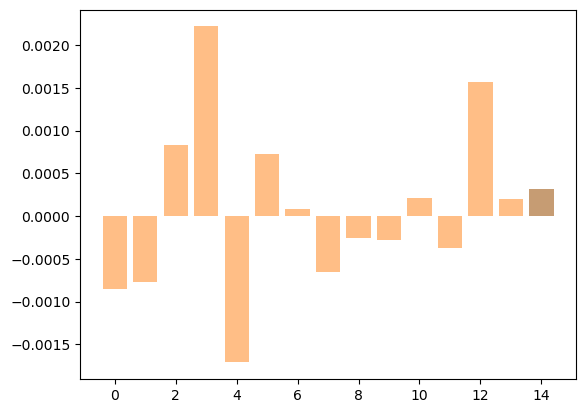

In [11]:
power = 1
U_decoupled = make_decoupling_sequence_unitary(rand_U, centralizer, power)
x_decoupled = vector_from_SU4(U_decoupled)
plt.bar(range(len(x_decoupled)), x_decoupled/(8*power), alpha=0.5)
plt.bar(range(len(x_decoupled)), rand_x, alpha=0.5)

<BarContainer object of 15 artists>

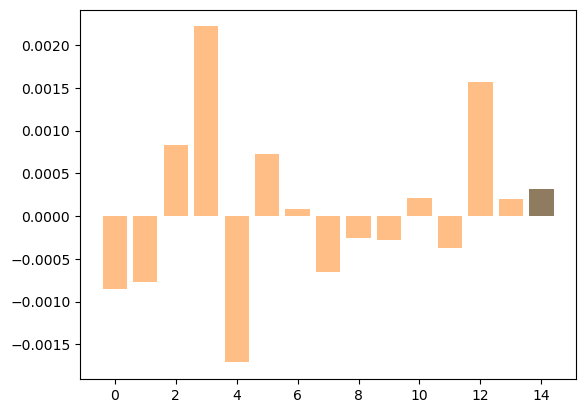

In [12]:
power = 100
U_decoupled = make_randomized_decoupling_sequence_unitary(rand_U, centralizer, power)
x_decoupled = vector_from_SU4(U_decoupled)
plt.bar(range(len(x_decoupled)), x_decoupled/(8*power))
plt.bar(range(len(x_decoupled)), rand_x, alpha=0.5)

In [13]:
from tqdm import tqdm

In [14]:
def average_matrix_norm_over_many_samples(x_covar, centralizer, power, n_samples, norm='fro'):
    total_error = 0
    # make a 1-hot encoding of the zz term
    for i in tqdm(range(n_samples)):
        rand_x = np.random.multivariate_normal(np.zeros(15), x_covar)
        one_hot = np.zeros(15)
        one_hot[14] = rand_x[14]
        
        rand_U = SU4_from_vector(rand_x)
        onehot_U = SU4_from_vector(one_hot)
        U_decoupled = make_decoupling_sequence_unitary(rand_U, centralizer, power)
        total_error += np.linalg.norm(U_decoupled - onehot_U, norm)
    return total_error/n_samples
        

def average_vector_norm_over_many_samples(x_covar, centralizer, power, n_samples, norm='fro'):
    total_error = 0
    # make a 1-hot encoding of the zz term
    for i in tqdm(range(n_samples)):
        rand_x = np.random.multivariate_normal(np.zeros(15), x_covar)
        one_hot = np.zeros(15)
        one_hot[14] = rand_x[14]
        rand_U = SU4_from_vector(rand_x)
        U_decoupled = make_decoupling_sequence_unitary(rand_U, centralizer, power)
        x_decoupled = vector_from_SU4(U_decoupled)
        total_error += np.linalg.norm(x_decoupled - one_hot, 2)
    return total_error/n_samples

In [15]:
average_matrix_norm_over_many_samples(0.1*np.eye(15), centralizer, 1, 100)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 1245.42it/s]


1.6719016341516724

In [16]:
average_vector_norm_over_many_samples(0.01*np.eye(15), centralizer, 1, 100)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 421.50it/s]


0.5785990268988861

In [17]:
# make a grid of the average 1-norm error over many samples for different covars
# for many powers
covar_line = [2**i for i in range(-10, 0)]
powers = [1, 10, 100, 1000]
n_samples = 100
error_trajs_power = {}
for power in powers:
    errors = []
    for covar in covar_line:
        errors.append(average_vector_norm_over_many_samples(covar*np.eye(15), centralizer, power, n_samples))
    error_trajs_power[power] = errors

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 355.94it/s]


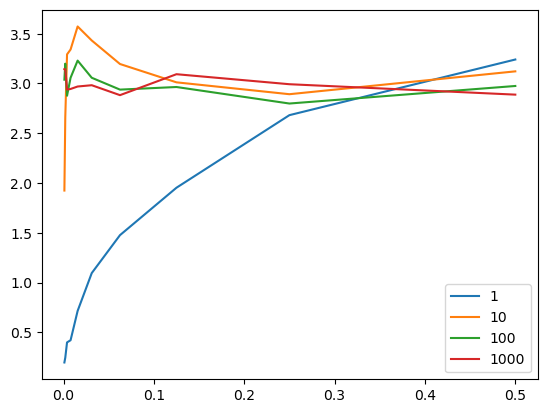

In [18]:
# plot them 
for power, errors in error_trajs_power.items():
    plt.plot(covar_line, errors, label=power)
plt.legend()

# Folded decoupling

In [35]:
def make_folded_decoupling_sequence(U, centralizer, power):
    U_seq = U
    sequence_length = 1
    for p in range(power):
        U_new = np.eye(4)
        subsequence_length = 0
        for c in centralizer:
            subsequence_length += 1
            U_new = c @ U_seq @ c @ U_new
        U_seq = U_new
        sequence_length *= subsequence_length
    return U_seq, sequence_length

In [42]:
rand_x = 0.01*np.random.randn(15)
rand_U = SU4_from_vector(rand_x)


In [85]:
centralizer = find_centralizer(np.kron(np.eye(2), SigY), PauliBasis_2Q)

In [92]:
power = 3
U_folded, sequence_length = make_folded_decoupling_sequence(rand_U, centralizer, power)
print(sequence_length)

512


In [93]:
is_unitary = lambda U: np.allclose(U @ U.T.conj(), np.eye(4))   
is_unitary(U_folded)

True

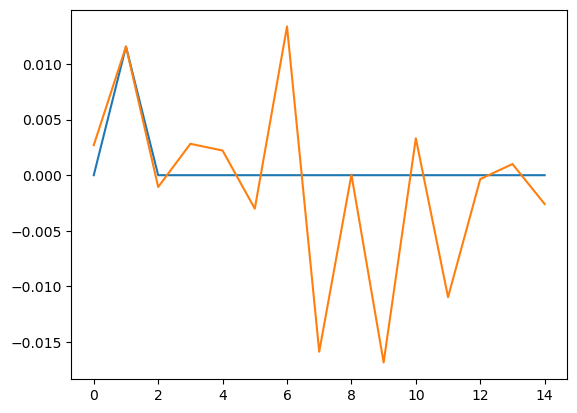

In [94]:
plt.plot(vector_from_SU4(U_folded)/(sequence_length))
plt.plot(rand_x)

# twiriling

In [24]:
def make_random_twirl_sequence(U, centralizer, num_reps):
    U_seq = np.eye(4)
    for rep in range(num_reps):
        # pick a c from centralizer
        c = centralizer[np.random.randint(len(centralizer))]
        U_seq = c @ U @ c @ U_seq
    return U_seq

In [25]:
num_twirls = 100
num_reps_per_twirl = 10
Us = []
for i in range(num_twirls):
    Us.append(make_random_twirl_sequence(rand_U, centralizer, num_reps_per_twirl))

In [26]:
rand_U

array([[ 0.96725833-0.09353142j, -0.07266899+0.01594419j,
         0.01736058+0.1414721j , -0.14727142-0.09013091j],
       [ 0.08799937+0.03165305j,  0.982048  +0.11285046j,
         0.00672331+0.01279497j,  0.02861359+0.11433744j],
       [-0.00162356+0.15521476j, -0.01352687-0.00958625j,
         0.9847465 -0.03842978j, -0.05076681+0.04302422j],
       [ 0.12581768-0.08362442j, -0.05415353+0.11876039j,
         0.065703  +0.06289626j,  0.97544773+0.01921276j]])

In [27]:
len(centralizer)

8

In [28]:
# print the sum of the twirls
sum_U = np.eye(4)

In [29]:
sum_U

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])